In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scrublet as scr
import scprep
import os
import re



In [2]:
pd.__version__

'1.4.2'

## Getting to know the data
* Cell IDs
* Cell class
* Cell type

In [4]:
series_txt = 'GSE84465_series_matrix.txt'
with open(series_txt, "r") as series:
    for line in series:
        if re.match("^!Sample_characteristics_ch1\s+\"tissue:", line):
            cell_class = line.rstrip()
            cell_class = re.split('"\t"tissue: |!Sample_characteristics_ch1\t"tissue: |"', cell_class)[1:-1]
        elif re.match("^!Sample_description\t\"\d+", line):
            cell_id = line.rstrip()
            cell_id = re.split('"\t"|!Sample_description\t"|"', cell_id)[1:-1]
        elif re.match("^!Sample_characteristics_ch1\s+\"cell\stype:", line):
            cell_type = line.rstrip()
            cell_type = re.split('"\t"cell type: |!Sample_characteristics_ch1\t"cell type: |"', cell_type)[1:-1]
series.close()

# Create a Y dataframe
id_class = list(zip(cell_id, cell_class))
Y = pd.DataFrame(id_class, columns=['Cell ID','Cell class'])
Y = Y.set_index('Cell ID')
Y
#label = Y[0]
#label

,Cell class
Cell ID,
1001000173.G8,Tumor
1001000173.D4,Tumor
1001000173.B4,Tumor
1001000173.A2,Tumor
1001000173.E2,Tumor
...,...
1001000271.F1,Tumor
1001000271.D4,Tumor
1001000271.C1,Tumor


In [5]:
labels = Y.replace('Tumor', 1)
labels = labels.replace('Periphery', 0)
labels = labels['Cell class']
labels

Cell ID
1001000173.G8    1
1001000173.D4    1
1001000173.B4    1
1001000173.A2    1
1001000173.E2    1
                ..
1001000271.F1    1
1001000271.D4    1
1001000271.C1    1
1001000271.H7    1
1001000271.H2    1
Name: Cell class, Length: 3589, dtype: int64

In [6]:
count_t = 0
count_p = 0
for i in cell_class:
    if i == "Tumor":
        count_t += 1
    elif i == "Periphery":
        count_p += 1
print("There are {} Tumor cells in the dataset".format(count_t))
print("There are {} Periphery cells in the dataset".format(count_p))


There are 2343 Tumor cells in the dataset
There are 1246 Periphery cells in the dataset


In [7]:
cell_types = set(cell_type)
for cell in cell_types:
    print("There are {} {} cells in the dataset".format(cell_type.count(cell), cell))

There are 1847 Immune cell cells in the dataset
There are 21 Neuron cells in the dataset
There are 1091 Neoplastic cells in the dataset
There are 406 OPC cells in the dataset
There are 85 Oligodendrocyte cells in the dataset
There are 51 Vascular cells in the dataset
There are 88 Astocyte cells in the dataset


In [8]:
cell_type_dict = {}
for i in range(len(cell_type)):
    cell_class[i]
    cell_type[i]
    pair = str(cell_class[i] + " " + cell_type[i])
    if pair not in cell_type_dict:
        cell_type_dict[pair] = 1
    else:
        cell_type_dict[pair] += 1

for pair in cell_type_dict:
    print("There are {} {} cells in the dataset".format(cell_type_dict[pair], pair))

There are 1029 Tumor Neoplastic cells in the dataset
There are 34 Tumor Oligodendrocyte cells in the dataset
There are 50 Tumor OPC cells in the dataset
There are 1182 Tumor Immune cell cells in the dataset
There are 1 Tumor Neuron cells in the dataset
There are 47 Tumor Vascular cells in the dataset
There are 665 Periphery Immune cell cells in the dataset
There are 62 Periphery Neoplastic cells in the dataset
There are 356 Periphery OPC cells in the dataset
There are 51 Periphery Oligodendrocyte cells in the dataset
There are 88 Periphery Astocyte cells in the dataset
There are 20 Periphery Neuron cells in the dataset
There are 4 Periphery Vascular cells in the dataset


**Read the dataset: The last 5 collumns have extra information about the dataset**

In [9]:
df_complete = pd.read_csv('GSE84465_GBM_All_data.csv', delimiter=' ')


In [10]:
# make samples as rows
df_complete = df_complete.T


In [11]:
# append "Labels" column
df_complete["Cell class"] = cell_class
df_complete["Cell type"] = cell_type
df_complete

,1/2-SBSRNA4,A1BG,A1BG-AS1,A1CF,A2LD1,A2M,A2ML1,A2MP1,A4GALT,A4GNT,...,ZZEF1,ZZZ3,tAKR,no_feature,ambiguous,too_low_aQual,not_aligned,alignment_not_unique,Cell class,Cell type
1001000173.G8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,429554,8372,0,0,111288,Tumor,Neoplastic
1001000173.D4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,73969,2297,0,0,19969,Tumor,Oligodendrocyte
1001000173.B4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,185910,12481,0,0,132812,Tumor,Neoplastic
1001000173.A2,0,0,1,0,0,0,34,0,0,0,...,33,1,0,355266,11386,0,0,131212,Tumor,Neoplastic
1001000173.E2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,536444,8969,0,0,145595,Tumor,Neoplastic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001000271.F1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,223514,3400,0,0,108873,Tumor,Vascular
1001000271.D4,0,61,0,0,0,2,0,0,0,0,...,0,0,0,173101,3605,0,0,64761,Tumor,Immune cell
1001000271.C1,0,0,0,0,0,61,0,0,2,0,...,0,64,0,349266,8243,0,0,114882,Tumor,Vascular
1001000271.H7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3117,34,0,0,507,Tumor,Vascular


In [12]:
# remove the last 7 columns 
df = df_complete.iloc[: , :-7]
df

,1/2-SBSRNA4,A1BG,A1BG-AS1,A1CF,A2LD1,A2M,A2ML1,A2MP1,A4GALT,A4GNT,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,tAKR
1001000173.G8,1,0,0,0,0,0,0,0,0,0,...,0,30,0,0,0,0,0,0,0,0
1001000173.D4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1001000173.B4,0,0,0,0,0,0,0,0,0,0,...,0,0,40,33,0,0,834,0,0,0
1001000173.A2,0,0,1,0,0,0,34,0,0,0,...,0,0,41,61,0,0,0,33,1,0
1001000173.E2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,439,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001000271.F1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1001000271.D4,0,61,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1001000271.C1,0,0,0,0,0,61,0,0,2,0,...,0,1,98,19,0,0,18,0,64,0
1001000271.H7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Pre-processing and Visualization


### Qaulity Control
Quality control is performed to ensure that the data quality is sufficient for downstream analysis. It will be performed on 3 levels:
* The number of counts per cell (count depth)
* The number of genes per cell
* The franction of counts from mitochondral genes per cell

We will examine these matrices for outliers which are going to be filtered out. These outliers can be either dying cells (high mitochindrial gene count) or douplets (unexpectedly high counts and large number of detected genes).

We have to consider the 3 QC covariates jointly in order to take univariate thresholding decision. Furthermore, we must avoid filtering out informative gene populations and genes.


#### **Step1: Create plots to find filtering thresholds**

In datasets with >20,000 genes (like our dataset), the general guideline is to filter out genes that are not expressed in more than a few cells (cell_threshold) and thus they are not informative of the cellular heterogeneity (common practice: use the minimum cell cluster sizs that is of interest and leaving some leeway for drop out effects).

We will start by using less strick thresholds (e.g. cell_threshold=0). Based on the results of downstrean analysis we will adjust these thresholds. The number of cells is getting reduced at cell_threshold=52.In datasets with >20,000 genes (like our dataset), the general guideline is to filter out genes that are not expressed in more than a few cells (cell_threshold) and thus they are not informative of the cellular heterogeneity (common practice: use the minimum cell cluster sizs that is of interest and leaving some leeway for drop out effects).

We will start by using less strick thresholds (e.g. cell_threshold=0). Based on the results of downstrean analysis we will adjust these thresholds. The number of cells is getting reduced at cell_threshold=52.

Revisit the QC thresholds if the results are abnormal

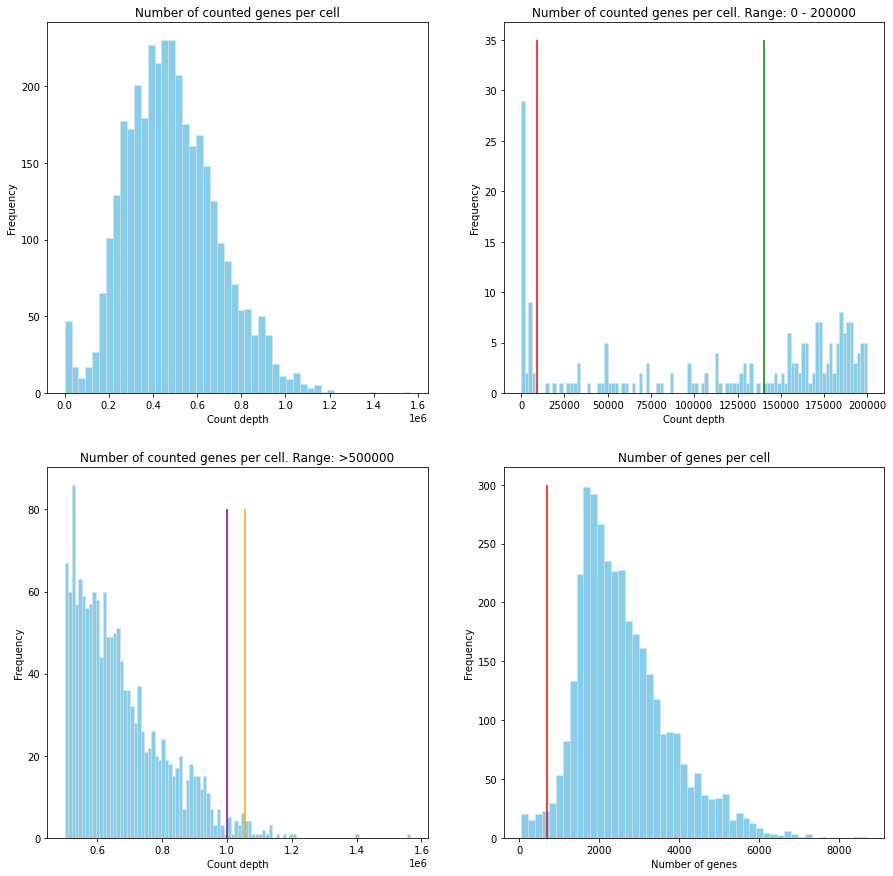

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(15,15))


# The number of counted  genes per cell
count_depth = df.sum(axis=1)
max(count_depth)
#print(count_depth.shape)
#print(count_depth.head())
plt.subplot(221),
plt.hist(count_depth, bins=50, facecolor = "skyblue", edgecolor='#e0e0e0', linewidth=0.5),
#plt.vlines(10000, 230, 0, color='red'),
plt.title('Number of counted genes per cell'), plt.xlabel("Count depth"), plt.ylabel("Frequency"),

plt.subplot(222),
count_list = []
for count in count_depth:
    if count < 200000:
        count_list.append(count)
plt.hist(count_list, bins=100, facecolor = "skyblue", edgecolor='#e0e0e0', linewidth=0.5),
plt.vlines(9000, 35, 0, color='red'),
plt.vlines(140000, 35, 0, color='green'), # Try that on a later stage
plt.title('Number of counted genes per cell. Range: 0 - 200000'), plt.xlabel("Count depth"), plt.ylabel("Frequency"),

plt.subplot(223),
count_list = []
for count in count_depth:
    if count > 500000:
        count_list.append(count)
plt.hist(count_list, bins=100, facecolor = "skyblue", edgecolor='#e0e0e0', linewidth=0.5),
plt.vlines(1055000, 80, 0, color='orange'),
plt.vlines(1000000, 80, 0, color='purple'), # Try that on a later stage
plt.title('Number of counted genes per cell. Range: >500000'), plt.xlabel("Count depth"), plt.ylabel("Frequency"),


# Number of genes per cell
num_genes = df.gt(0).sum(axis=1)
#print(num_genes.shape)
#print(num_genes.head())
plt.subplot(224),
plt.hist(num_genes, bins=50, facecolor = "skyblue", edgecolor='#e0e0e0', linewidth=0.5)
plt.vlines(700, 300, 0, color='red'),
plt.title('Number of genes per cell'), plt.xlabel("Number of genes"), plt.ylabel("Frequency"),

plt.show()

(Text(0.5, 1.0, 'Number of counted genes per cell'),
 Text(0.5, 0, 'Count depth'),
 Text(0, 0.5, 'Frequency'))

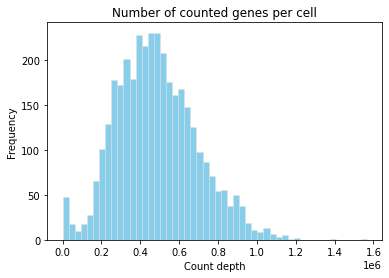

In [14]:
count_depth = df.sum(axis=1)
max(count_depth)
#print(count_depth.shape)
#print(count_depth.head())
plt.subplot(111),
plt.hist(count_depth, bins=50, facecolor = "skyblue", edgecolor='#e0e0e0', linewidth=0.5),
#plt.vlines(10000, 230, 0, color='red'),
plt.title('Number of counted genes per cell'), plt.xlabel("Count depth"), plt.ylabel("Frequency"),

(Text(0.5, 1.0, 'Number of counted genes per cell. Range: 0 - 200000'),
 Text(0.5, 0, 'Count depth'),
 Text(0, 0.5, 'Frequency'))

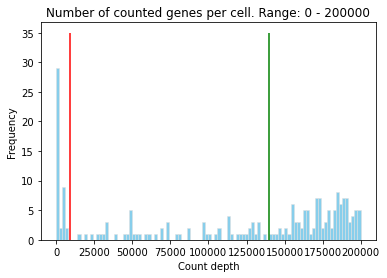

In [15]:
count_list = []
for count in count_depth:
    if count < 200000:
        count_list.append(count)
plt.hist(count_list, bins=100, facecolor = "skyblue", edgecolor='#e0e0e0', linewidth=0.5),
plt.vlines(9000, 35, 0, color='red'),
plt.vlines(140000, 35, 0, color='green'), # Try that on a later stage
plt.title('Number of counted genes per cell. Range: 0 - 200000'), plt.xlabel("Count depth"), plt.ylabel("Frequency"),


(Text(0.5, 1.0, 'Number of counted genes per cell. Range: >500000'),
 Text(0.5, 0, 'Count depth'),
 Text(0, 0.5, 'Frequency'))

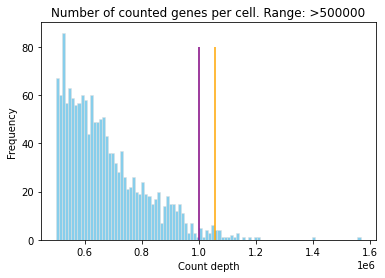

In [21]:
count_list = []
for count in count_depth:
    if count > 500000:
        count_list.append(count)
plt.hist(count_list, bins=100, facecolor = "skyblue", edgecolor='#e0e0e0', linewidth=0.5),
plt.vlines(1055000, 80, 0, color='orange'),
plt.vlines(1000000, 80, 0, color='purple'), # Try that on a later stage
plt.title('Number of counted genes per cell. Range: >500000'), plt.xlabel("Count depth"), plt.ylabel("Frequency"),


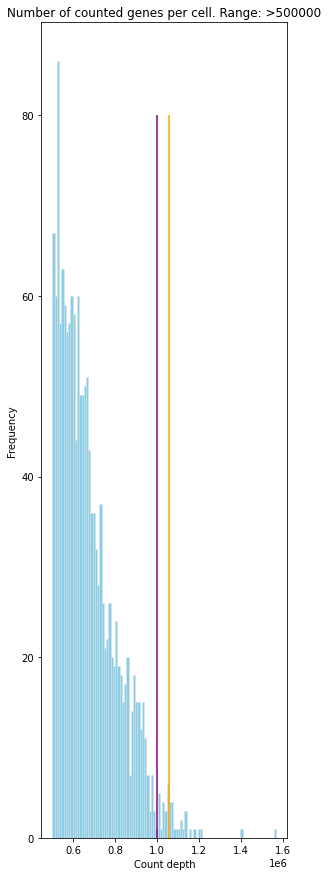

In [18]:
fig, axes = plt.subplots(1,3, figsize=(15,15))


# The number of counted  genes per cell
count_depth = df.sum(axis=1)
max(count_depth)
#print(count_depth.shape)
#print(count_depth.head())
plt.subplot(111),
plt.hist(count_depth, bins=50, facecolor = "skyblue", edgecolor='#e0e0e0', linewidth=0.5),
#plt.vlines(10000, 230, 0, color='red'),
plt.title('Number of counted genes per cell'), plt.xlabel("Count depth"), plt.ylabel("Frequency"),

plt.subplot(121),
count_list = []
for count in count_depth:
    if count < 200000:
        count_list.append(count)
plt.hist(count_list, bins=100, facecolor = "skyblue", edgecolor='#e0e0e0', linewidth=0.5),
plt.vlines(9000, 35, 0, color='red'),
plt.vlines(140000, 35, 0, color='green'), # Try that on a later stage
plt.title('Number of counted genes per cell. Range: 0 - 200000'), plt.xlabel("Count depth"), plt.ylabel("Frequency"),

plt.subplot(131),
count_list = []
for count in count_depth:
    if count > 500000:
        count_list.append(count)
plt.hist(count_list, bins=100, facecolor = "skyblue", edgecolor='#e0e0e0', linewidth=0.5),
plt.vlines(1055000, 80, 0, color='orange'),
plt.vlines(1000000, 80, 0, color='purple'), # Try that on a later stage
plt.title('Number of counted genes per cell. Range: >500000'), plt.xlabel("Count depth"), plt.ylabel("Frequency"),


## Number of genes per cell
#num_genes = df.gt(0).sum(axis=1)
##print(num_genes.shape)
##print(num_genes.head())
#plt.subplot(224),
#plt.hist(num_genes, bins=50, facecolor = "skyblue", edgecolor='#e0e0e0', linewidth=0.5)
#plt.vlines(700, 300, 0, color='red'),
#plt.title('Number of genes per cell'), plt.xlabel("Number of genes"), plt.ylabel("Frequency"),
#
plt.show()

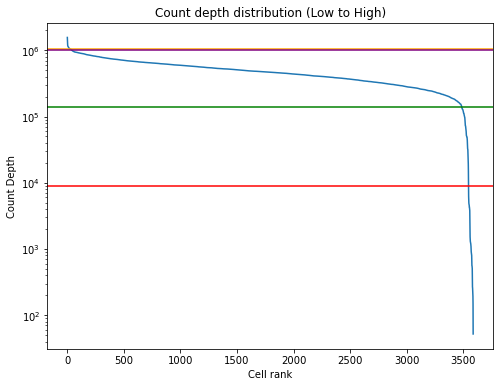

In [16]:
distr = count_depth.sort_values(ascending=False)
x = range(len(count_depth))
plt.figure(figsize=(8, 6))
plt.plot(x, distr.values), plt.yscale('log')
plt.title('Count depth distribution (Low to High)'), plt.xlabel("Cell rank"), plt.ylabel("Count Depth"),
plt.axhline(9000, 35, 0, color='red'),
plt.axhline(140000, 35, 0, color='green'),
plt.axhline(1055000, 35, 0, color='orange'),
plt.axhline(1000000, 35, 0, color='purple'),

plt.show() 

#### **Step3: Find outliers #dont know if we are going to apply that**

In [24]:
#https://github.com/swolock/scrublet
scrub_1 = scr.Scrublet(df_qc)
doublet_scores_1, predicted_doublets_1 = scrub_1.scrub_doublets()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.52
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 31.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.2%
Elapsed time: 11.3 seconds


**To call doublets vs. singlets, we must set a threshold doublet score, ideally at the minimum between the two modes of the simulated doublet histogram.**

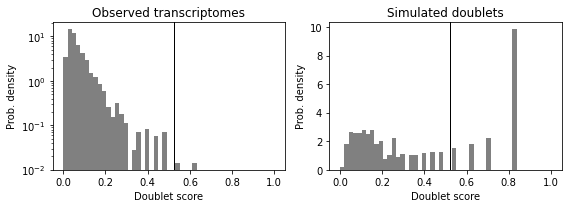

In [25]:
#scrub_1.call_doublets(threshold=0.32)
scrub_1.plot_histogram();

**Predicted doublets should co-localize in distinct states.**

Running UMAP...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Done.


(<Figure size 576x288 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Predicted doublets'}, xlabel='UMAP 1', ylabel='UMAP 2'>,
        <AxesSubplot:title={'center':'Doublet score'}, xlabel='UMAP 1', ylabel='UMAP 2'>],
       dtype=object))

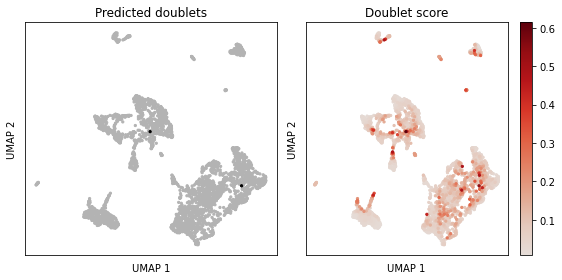

In [26]:
print('Running UMAP...')
scrub_1.set_embedding('UMAP', scr.get_umap(scrub_1.manifold_obs_, 10, min_dist=0.3))
print('Done.')

scrub_1.plot_embedding('UMAP', order_points=True)

In [18]:
predicted_douplet = ~pd.Series(predicted_doublets_1, df_1.index.values)

#### **Step4: Apply filtering**

Based on the above results we are able to apply a threshold of 140000 based on the abnormal beak detected at around 6000 bases and because we observe a rapid decrease in the count deapth at that certain points

A small noise pick is detected at around 400 genes. We apply a threshold at 700 genes.

We also remove the outliers.

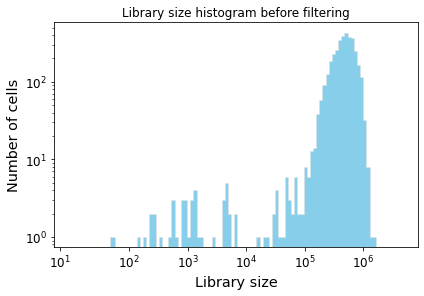

In [16]:
scprep.plot.plot_library_size(df, facecolor = "skyblue", edgecolor='#e0e0e0', linewidth=0.5 )
plt.title("Library size histogram before filtering")
plt.show()

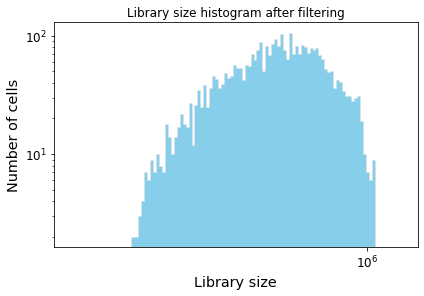

In [17]:
df_qc = scprep.filter.filter_library_size(df, cutoff= 140000, keep_cells='above') # green
df_qc = scprep.filter.filter_library_size(df_qc, cutoff= 1055000, keep_cells='below') # orange
scprep.plot.plot_library_size(df_qc, facecolor = "skyblue", edgecolor='#e0e0e0', linewidth=0.5)
plt.title("Library size histogram after filtering")

plt.show()

In [18]:
df_qc.shape

(3465, 23460)

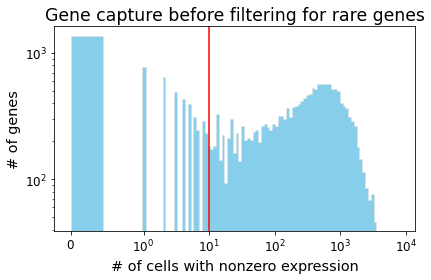

In [19]:
scprep.plot.histogram(scprep.measure.gene_capture_count(df_qc), log=True, cutoff = 10,
                      title="Gene capture before filtering for rare genes",
                     xlabel='# of cells with nonzero expression',
                     ylabel='# of genes',
                     facecolor = "skyblue", edgecolor='#e0e0e0', linewidth=0.5)
plt.show()

In [20]:
df_qc = scprep.filter.remove_rare_genes(df_qc, cutoff=0, min_cells=10)
df_qc.shape

(3465, 18258)

<AxesSubplot:title={'center':'Gene capture after filtering for rare genes'}, xlabel='# of cells with nonzero expression', ylabel='# of genes'>

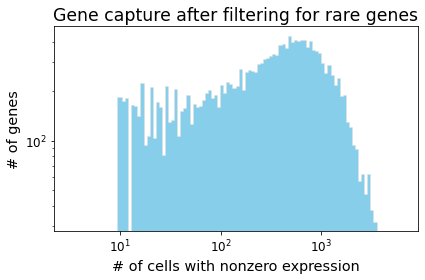

In [21]:
# ================
# choose a cutoff
scprep.plot.histogram(scprep.measure.gene_capture_count(df_qc),
                      log=True,
                      title="Gene capture after filtering for rare genes",
                      xlabel='# of cells with nonzero expression',
                      ylabel='# of genes',
                     facecolor = "skyblue", edgecolor='#e0e0e0', linewidth=0.5)
# ================

 There are no mitochondrial genes !!!!!!!!!!! check again

In [22]:
mitochondrial_gene_list = np.array([g.startswith('MT-') for g in df_qc.columns])
print(mitochondrial_gene_list.sum())

#df_mit = scprep.filter.filter_values(df_1, mito_expression, percentile=95, keep_cells='below')

0


### Normalization

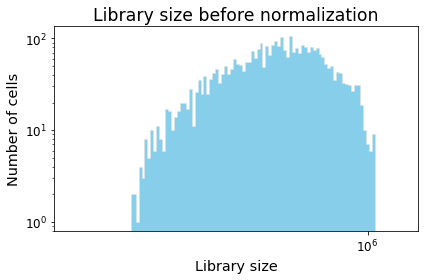

In [23]:
scprep.plot.plot_library_size(df_qc, title='Library size before normalization',
                     facecolor = "skyblue", edgecolor='#e0e0e0', linewidth=0.5)
plt.show()

In [24]:
data_norm, library_size = scprep.normalize.library_size_normalize(df_qc, return_library_size=True)

In [27]:
data_norm.sum(axis = 1)

1001000173.G8    10000.0
1001000173.D4    10000.0
1001000173.B4    10000.0
1001000173.A2    10000.0
1001000173.E2    10000.0
                  ...   
1001000271.E1    10000.0
1001000271.F1    10000.0
1001000271.D4    10000.0
1001000271.C1    10000.0
1001000271.H2    10000.0
Length: 3465, dtype: float64

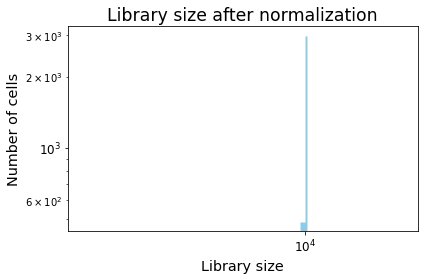

In [25]:
scprep.plot.plot_library_size(data_norm, title='Library size after normalization',
                     facecolor = "skyblue", edgecolor='#e0e0e0', linewidth=0.5)
plt.show()

### Visualization and dataset preparassion for further steps

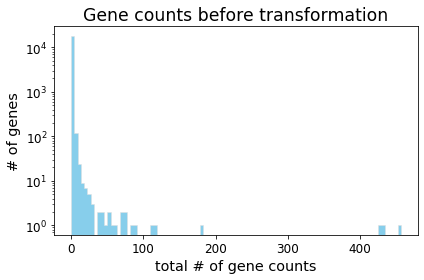

In [39]:
scprep.plot.histogram(data_norm.mean(axis=0), log='y',
                      title="Gene counts before transformation",
                     xlabel='total # of gene counts',
                     ylabel='# of genes',
                     facecolor = "skyblue", edgecolor='#e0e0e0', linewidth=0.5)
plt.show()

In order to avoid these high-expression genes dominating the variation, the data is often  log -transformed. This typically requires the addition of some small value to avoid taking  log(0) . We avoid this issue entirely by instead taking the square root transform. The square root function has a similar form as the  log  function with the added benefit of being stable at 0.

In [40]:
data_log  = scprep.transform.log(data_norm+1)
data_sq  = scprep.transform.sqrt(data_norm)

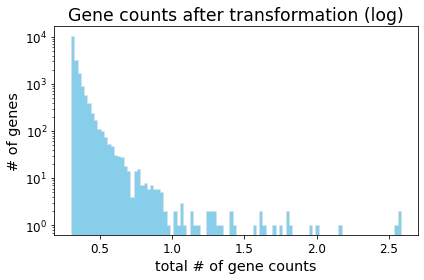

In [41]:
scprep.plot.histogram(data_log.mean(axis=0), log='y',
                      title="Gene counts after transformation (log)",
                     xlabel='total # of gene counts',
                     ylabel='# of genes',
                     facecolor = "skyblue", edgecolor='#e0e0e0', linewidth=0.5)
plt.show()

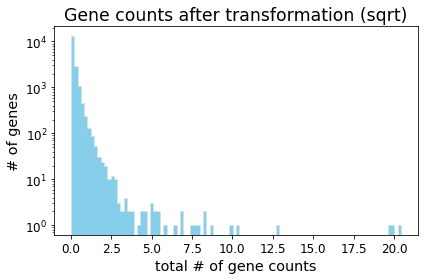

In [42]:
scprep.plot.histogram(data_sq.mean(axis=0), log='y',
                      title="Gene counts after transformation (sqrt)",
                     xlabel='total # of gene counts',
                     ylabel='# of genes',
                     facecolor = "skyblue", edgecolor='#e0e0e0', linewidth=0.5)
plt.show()

In [43]:
data_sq.shape

(3465, 18258)

Text(0.5, 1.0, 'Highly Variable Genes (5%)')

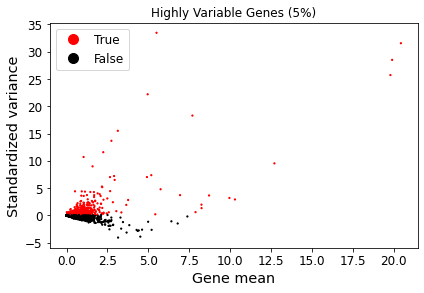

In [33]:
scprep.plot.plot_gene_variability(data_sq, percentile=95)
plt.title("Highly Variable Genes (5%)")

Text(0.5, 1.0, 'Highly Variable Genes (10%)')

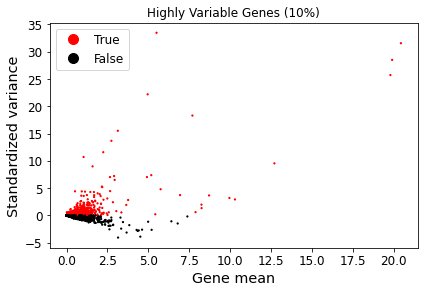

In [34]:
scprep.plot.plot_gene_variability(data_sq, percentile=90)
plt.title("Highly Variable Genes (10%)")

In [49]:
data_hvg_95 = scprep.select.highly_variable_genes(data_sq, percentile=95)
data_hvg_95.shape

(3465, 913)

In [50]:
data_hvg = scprep.select.highly_variable_genes(data_sq, percentile=90)
data_hvg.shape

(3465, 1826)

In [51]:
metadata = df_complete.iloc[: , -7:]
metadata = pd.concat([metadata, library_size], axis=1)
sample_labels_full = df.index
sample_labels_final = data_hvg.index

In [52]:
print(len(sample_labels_full))
print(len(sample_labels_final))

3589
3465


In [53]:
rows = list(set(df.index) - set(data_hvg.index))
metadata_final = metadata.drop(rows)

In [41]:
# Save datasets

#Add label column to dataframe
#df = pd.concat([df, sample_labels_full], axis=1)

df.to_pickle("data_original.pkl")
df_qc.to_pickle("data_filtered.pkl")
data_norm.to_pickle("data_normalized.pkl")
data_log.to_pickle("data_normalized_log.pkl")
data_sq.to_pickle("data_normalized_sqrt.pkl")
data_hvg.to_pickle("data_normalized_highly_variable_genes.pkl")
data_hvg_95.to_pickle("data_normalized_highly_variable_genes_95.pkl")
metadata.to_pickle("metadata.pkl")
metadata_final.to_pickle("metadata_final.pkl")
#pd.read_pickle("data_normalized.pkl")


In [188]:
pd.read_pickle("data_original.pkl")

,1/2-SBSRNA4,A1BG,A1BG-AS1,A1CF,A2LD1,A2M,A2ML1,A2MP1,A4GALT,A4GNT,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,tAKR
1001000173.G8,1,0,0,0,0,0,0,0,0,0,...,0,30,0,0,0,0,0,0,0,0
1001000173.D4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1001000173.B4,0,0,0,0,0,0,0,0,0,0,...,0,0,40,33,0,0,834,0,0,0
1001000173.A2,0,0,1,0,0,0,34,0,0,0,...,0,0,41,61,0,0,0,33,1,0
1001000173.E2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,439,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001000271.F1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1001000271.D4,0,61,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1001000271.C1,0,0,0,0,0,61,0,0,2,0,...,0,1,98,19,0,0,18,0,64,0
1001000271.H7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
print("Shape of {}: {}". format("df", df.shape))
print("Shape of {}: {}". format("df_qc", df_qc.shape))
print("Shape of {}: {}". format("data_norm", data_norm.shape))
print("Shape of {}: {}". format("data_log", data_log.shape))
print("Shape of {}: {}". format("data_sq", data_sq.shape))
print("Shape of {}: {}". format("data_hvg", data_hvg.shape))
print("Shape of {}: {}". format("metadata", metadata.shape))
print("Shape of {}: {}". format("metadata_final", metadata_final.shape))

Shape of df: (3589, 23460)
Shape of df_qc: (3465, 18258)
Shape of data_norm: (3465, 18258)
Shape of data_log: (3465, 18258)
Shape of data_sq: (3465, 18258)
Shape of data_hvg: (3465, 1826)
Shape of metadata: (3589, 8)
Shape of metadata_final: (3465, 8)


In [55]:
data_phate = phate.PHATE().fit_transform(data_hvg)

NameError: name 'phate' is not defined

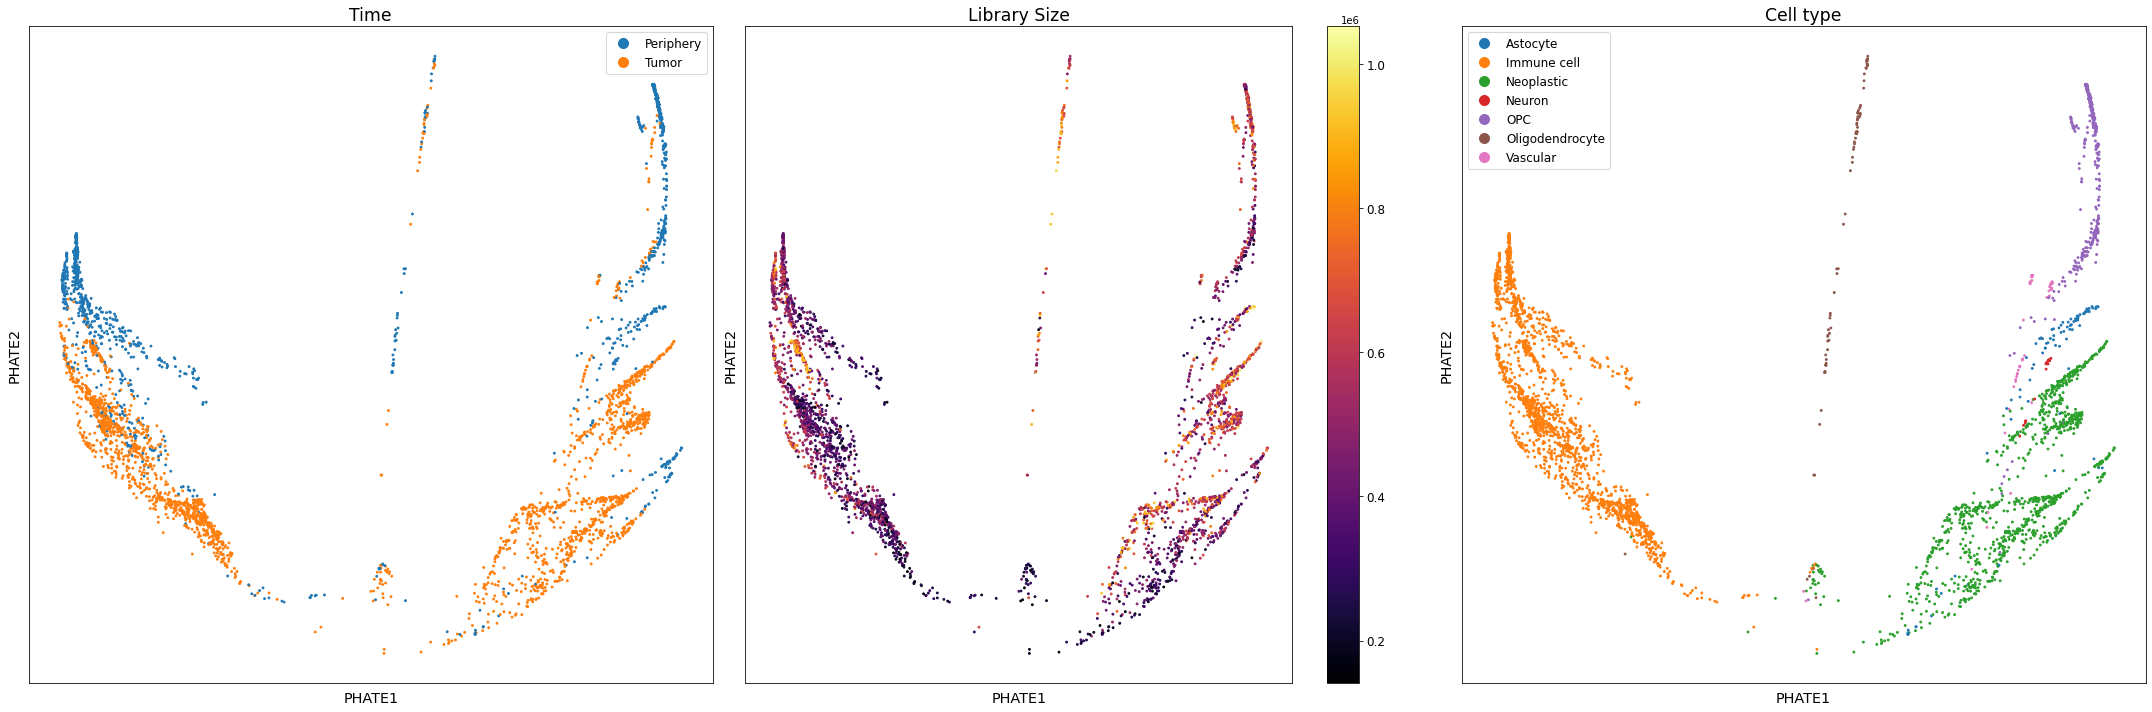

In [116]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
scprep.plot.scatter2d(data_phate, c=metadata_final['Cell class'], title='Tumor-Periphery',
                      ticks=False, ax=axes[0], label_prefix='PHATE')
scprep.plot.scatter2d(data_phate, c=metadata_final['library_size'], title='Library Size',# cmap_scale='log',
                      ticks=False, ax=axes[1], label_prefix='PHATE')
scprep.plot.scatter2d(data_phate, c=metadata_final['Cell type'], title='Cell type',# cmap_scale='log',
                      ticks=False, ax=axes[2], label_prefix='PHATE')
plt.tight_layout()